<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

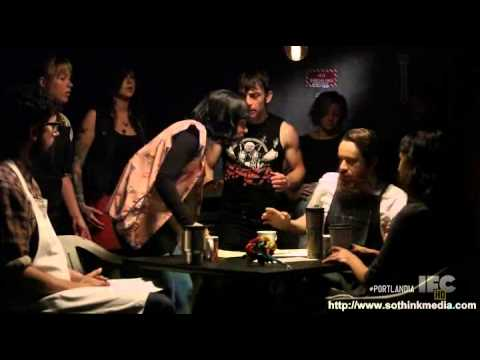

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/austie/PycharmProjects/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [4]:
# Start here

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [5]:
good_shops = shops[((shops['star_rating']==' 4.0 star rating ') | (shops['star_rating']==' 5.0 star rating '))]

In [6]:
bad_shops = shops[((shops['star_rating']!=' 4.0 star rating ') & (shops['star_rating']!=' 5.0 star rating '))]

In [7]:
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter

nlp = spacy.load("en_core_web_lg")

In [8]:
tokenizer = Tokenizer(nlp.vocab)

In [9]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [51]:
STOP_WORDS = nlp.Defaults.stop_words.union(['i', 'I', ' ', "i'm", "i've", 'it', "it's", 'it.', 'the', 'this', 'coffee'])

In [109]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [134]:
tokens = []
lemmas = []
stems = []

for doc in tokenizer.pipe(good_shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    doc_lemmas = []
    doc_stems = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False) & (token.text.lower() not in STOP_WORDS) & (token.like_num == False):
            doc_tokens.append(token.text.lower())
        if ((token.is_stop == False) and (token.is_punct == False)) & (token.text.lower() not in STOP_WORDS) and (token.like_num == False) and (token.pos_ != 'PRON'):
            doc_lemmas.append(token.lemma_)
        if ((token.is_stop == False) and (token.is_punct == False)) & (token.text.lower() not in STOP_WORDS) and (token.pos_ != 'PRON') & (token.like_num == False):
            doc_stems.append(ps.stem(token.text))

    tokens.append(doc_tokens)
    lemmas.append(doc_lemmas)
    stems.append(doc_stems)

good_shops['tokens'] = tokens
good_shops['lemmas'] = lemmas
good_shops['stems'] = stems

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [123]:
tokens = []
lemmas = []
stems = []

for doc in tokenizer.pipe(bad_shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    doc_lemmas = []
    doc_stems = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False) & (token.text.lower() not in STOP_WORDS) & (token.like_num == False):
            doc_tokens.append(token.text.lower())
        if ((token.is_stop == False) and (token.is_punct == False)) & (token.text.lower() not in STOP_WORDS) and (token.like_num == False) and (token.pos_ != 'PRON'):
            doc_lemmas.append(token.lemma_)
        if ((token.is_stop == False) and (token.is_punct == False)) & (token.text.lower() not in STOP_WORDS) and (token.pos_ != 'PRON') & (token.like_num == False):
            doc_stems.append(ps.stem(token.text))

    tokens.append(doc_tokens)
    lemmas.append(doc_lemmas)
    stems.append(doc_stems)

bad_shops['tokens'] = tokens
bad_shops['lemmas'] = lemmas
bad_shops['stems'] = stems

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [135]:
wc_good_tokens = count(good_shops['tokens'])
wc_good_lemmas = count(good_shops['lemmas'])
wc_good_stems = count(good_shops['stems'])
wc_bad_tokens = count(bad_shops['tokens'])
wc_bad_lemmas = count(bad_shops['lemmas'])
wc_bad_stems = count(bad_shops['stems'])

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [63]:
import squarify
import matplotlib.pyplot as plt

In [136]:
wc_top20good = wc_good_tokens[wc_good_tokens['rank'] <= 20]
wc_top20bad = wc_bad_tokens[wc_bad_tokens['rank'] <= 20]
wcdiff = wc_top20good.set_index('word').join(wc_top20bad.set_index('word'), on='word', how='inner', lsuffix='_good', rsuffix='_bad')
wcdiff['diff'] = wcdiff['pct_total_good'] - wcdiff['pct_total_bad']
wcdiff['abs_diff'] = abs(wcdiff['pct_total_good'] - wcdiff['pct_total_bad'])
wcdiff['abs_diff'].sort_values(ascending=False)[:10]

word
great       0.005703
like        0.002942
don't       0.001861
little      0.001204
check-in    0.001153
place       0.001058
food        0.001033
time        0.000818
pretty      0.000807
nice        0.000550
Name: abs_diff, dtype: float64

In [137]:
wc_top20good_lemmas = wc_good_lemmas[wc_good_lemmas['rank'] <= 20]
wc_top20bad_lemmas = wc_bad_lemmas[wc_bad_lemmas['rank'] <= 20]
wcdiff_lemmas = wc_top20good_lemmas.set_index('word').join(wc_top20bad_lemmas.set_index('word'), on='word', how='inner', lsuffix='_good', rsuffix='_bad')
wcdiff_lemmas['diff'] = wcdiff_lemmas['pct_total_good'] - wcdiff_lemmas['pct_total_bad']
wcdiff_lemmas['abs_diff'] = abs(wcdiff_lemmas['pct_total_good'] - wcdiff_lemmas['pct_total_bad'])
wcdiff_lemmas['abs_diff'].sort_values(ascending=False)[:10]

word
order       0.003425
check-in    0.003111
like        0.002860
place       0.001217
come        0.001077
food        0.001059
time        0.001000
drink       0.000972
get         0.000472
try         0.000355
Name: abs_diff, dtype: float64

In [138]:
wc_top20good_stems = wc_good_stems[wc_good_stems['rank'] <= 20]
wc_top20bad_stems = wc_bad_stems[wc_bad_stems['rank'] <= 20]
wcdiff_stems = wc_top20good_stems.set_index('word').join(wc_top20bad_stems.set_index('word'), on='word', how='inner', lsuffix='_good', rsuffix='_bad')
wcdiff_stems['diff'] = wcdiff_stems['pct_total_good'] - wcdiff_stems['pct_total_bad']
wcdiff_stems['abs_diff'] = abs(wcdiff_stems['pct_total_good'] - wcdiff_stems['pct_total_bad'])
wcdiff_stems['abs_diff'].sort_values(ascending=False)[:10]

word
great       0.005708
order       0.003622
like        0.003165
check-in    0.003118
place       0.001254
time        0.001059
drink       0.001035
food        0.001021
tri         0.000561
good        0.000349
Name: abs_diff, dtype: float64

### Words with greatest absolute difference between good and bad coffee shops


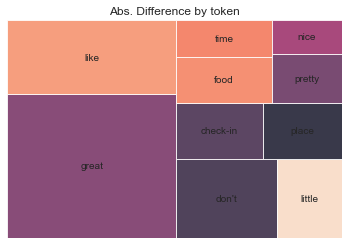

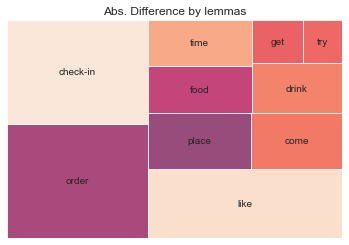

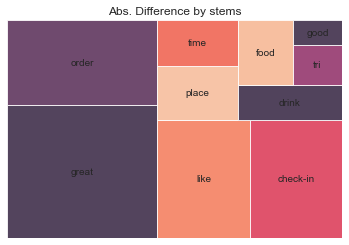

In [145]:
squarify.plot(sizes=wcdiff['abs_diff'].sort_values(ascending=False)[:10], label=wcdiff['abs_diff'].sort_values(ascending=False).index[:10], alpha=.8)
plt.axis('off')
plt.title('Abs. Difference by token')
plt.show()
squarify.plot(sizes=wcdiff_lemmas['abs_diff'].sort_values(ascending=False)[:10], label=wcdiff_lemmas['abs_diff'].sort_values(ascending=False).index[:10], alpha=.8)
plt.axis('off')
plt.title('Abs. Difference by lemmas')
plt.show()
squarify.plot(sizes=wcdiff_stems['abs_diff'].sort_values(ascending=False)[:10], label=wcdiff_stems['abs_diff'].sort_values(ascending=False).index[:10], alpha=.8)
plt.axis('off')
plt.title('Abs. Difference by stems')
plt.show()

### Words with greatest true difference and absolute difference

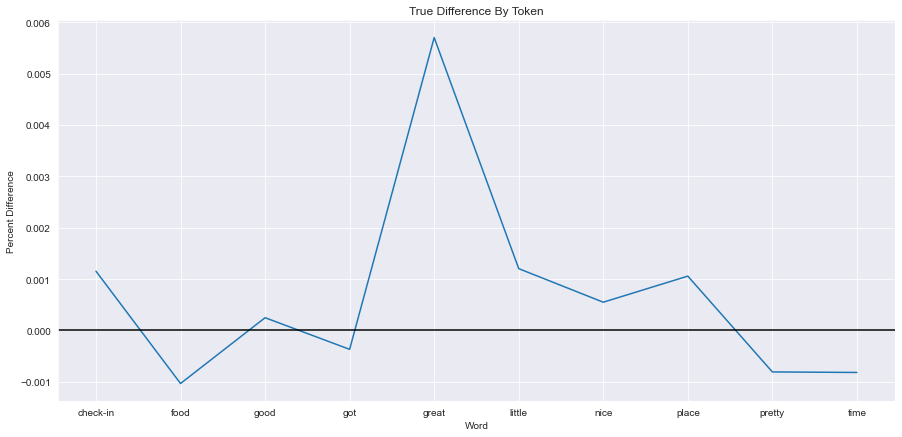

In [149]:
import seaborn as sns
fig, ax = plt.subplots()
sns.lineplot(x=wcdiff['diff'].sort_values(ascending=False).index[:10], y=wcdiff['diff'].sort_values(ascending=False)[:10])
sns.set_style('darkgrid')
fig.set_size_inches(15,7)
plt.xlabel('Word')
plt.ylabel('Percent Difference')
plt.title('True Difference By Token')
ax.axhline(0, ls='-', color='black')

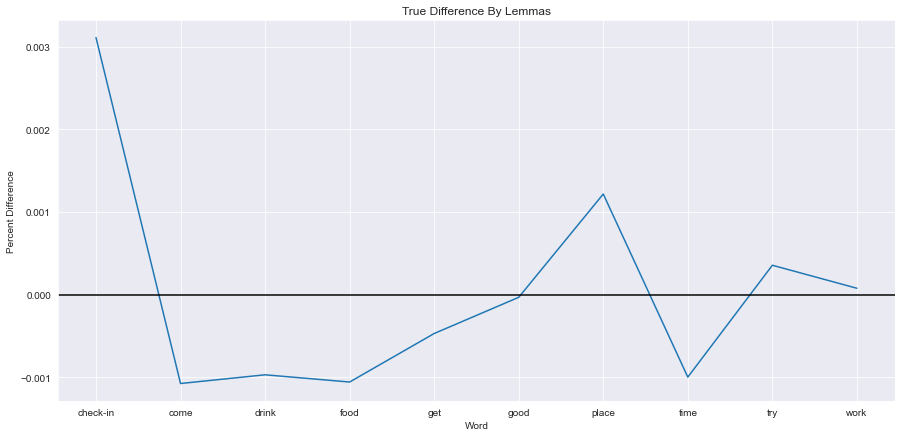

In [151]:
fig, ax = plt.subplots()
sns.lineplot(x=wcdiff_lemmas['diff'].sort_values(ascending=False).index[:10], y=wcdiff_lemmas['diff'].sort_values(ascending=False)[:10])
sns.set_style('darkgrid')
fig.set_size_inches(15,7)
plt.xlabel('Word')
plt.ylabel('Percent Difference')
plt.title('True Difference By Lemmas')
ax.axhline(0, ls='-', color='black')

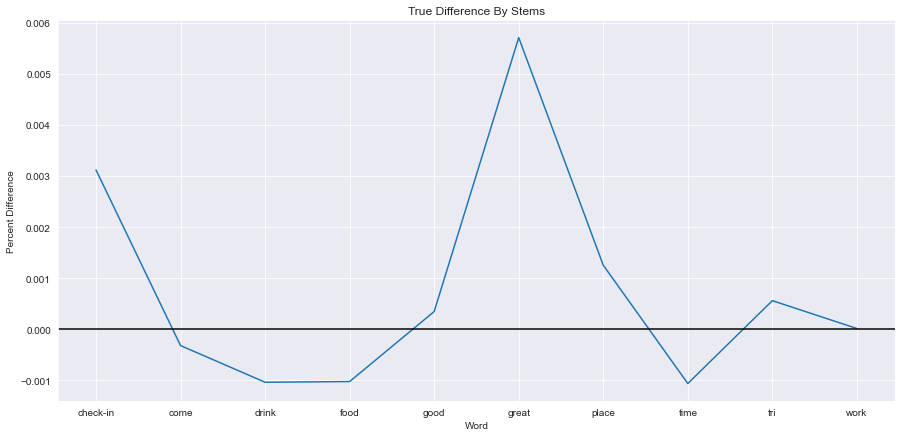

In [152]:
fig, ax = plt.subplots()
sns.lineplot(x=wcdiff_stems['diff'].sort_values(ascending=False).index[:10], y=wcdiff_stems['diff'].sort_values(ascending=False)[:10])
sns.set_style('darkgrid')
fig.set_size_inches(15,7)
plt.xlabel('Word')
plt.ylabel('Percent Difference')
plt.title('True Difference By Stems')
ax.axhline(0, ls='-', color='black')

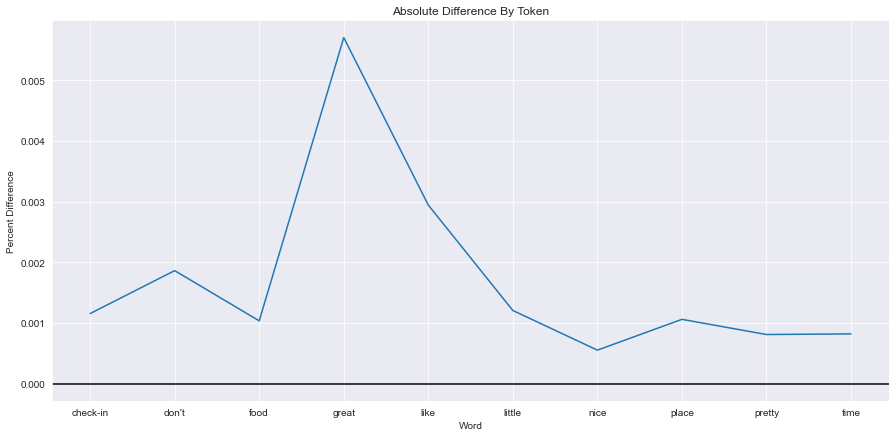

In [154]:
fig, ax = plt.subplots()
sns.lineplot(x=wcdiff['abs_diff'].sort_values(ascending=False).index[:10], y=wcdiff['abs_diff'].sort_values(ascending=False)[:10])
sns.set_style('darkgrid')
fig.set_size_inches(15,7)
plt.xlabel('Word')
plt.ylabel('Percent Difference')
plt.title('Absolute Difference By Token')
ax.axhline(0, ls='-', color='black')

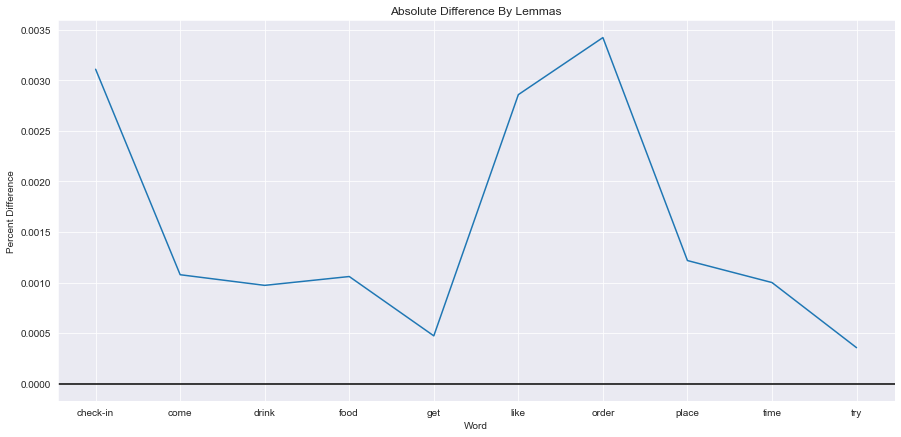

In [156]:
fig, ax = plt.subplots()
sns.lineplot(x=wcdiff_lemmas['abs_diff'].sort_values(ascending=False).index[:10], y=wcdiff_lemmas['abs_diff'].sort_values(ascending=False)[:10])
sns.set_style('darkgrid')
fig.set_size_inches(15,7)
plt.xlabel('Word')
plt.ylabel('Percent Difference')
plt.title('Absolute Difference By Lemmas')
ax.axhline(0, ls='-', color='black')

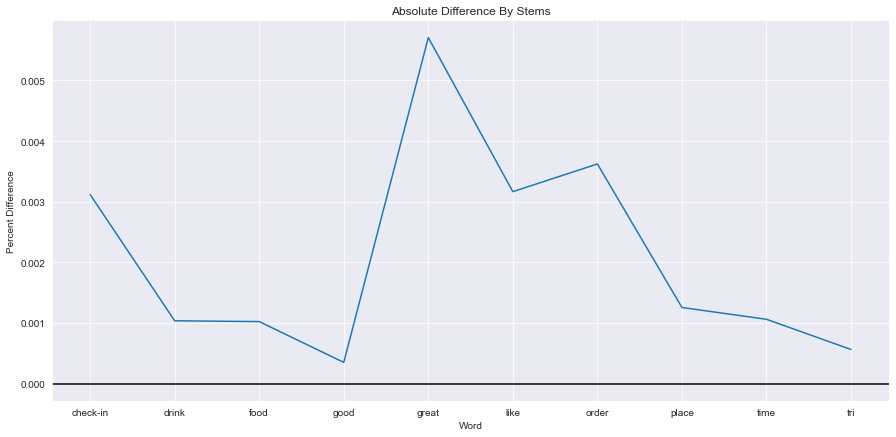

In [158]:
fig, ax = plt.subplots()
sns.lineplot(x=wcdiff_stems['abs_diff'].sort_values(ascending=False).index[:10], y=wcdiff_stems['abs_diff'].sort_values(ascending=False)[:10])
sns.set_style('darkgrid')
fig.set_size_inches(15,7)
plt.xlabel('Word')
plt.ylabel('Percent Difference')
plt.title('Absolute Difference By Stems')
ax.axhline(0, ls='-', color='black')

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

